# Seasonal dummy features: Linear models
Conda environment: `time-series`    
14 April 2024

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
import re
from tqdm import tqdm

from sklearn import set_config
from sklearn.base import clone
from sklearn.pipeline import make_pipeline, make_union
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sktime.transformations.series.summarize import WindowSummarizer
from sktime.transformations.series.time_since import TimeSince
from sktime.transformations.series.date import DateTimeFeatures
from sklearn.preprocessing import OneHotEncoder


from sklearn.linear_model import Lasso, LinearRegression, Ridge, ElasticNet

from sklearn.metrics import mean_squared_error

In [24]:
# Configs

# Plot configs:
sns.set_context("paper", font_scale= 1.5)
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plotsize = (22, 5)
plt.rcParams['figure.figsize'] = plotsize

# Pandas config
pd.options.display.float_format = '{:,.4f}'.format
pd.options.display.max_columns = 200

# Output a pandas df intead of numpy
set_config(transform_output="pandas")

In [25]:
# Functions
def c_mape(y: pd.Series, y_hat: pd.Series) -> np.float64:
    """
    Implements Mean Absolute Percent Error (MAPE).
    Args:
        y: actual values.
        y_hat: predicted values.
    Returns:
        MAPE value (Not in %)
    """
    if not (isinstance(y, pd.Series) and isinstance(y_hat, pd.Series)):
        y, y_hat = pd.Series(y), pd.Series(y_hat)
    mape = np.mean(np.abs((y - y_hat) / y))
    return np.round(mape, 4)

# 1) Input data

In [26]:
data = pd.read_csv(
    "../Datasets/victoria_electricity_demand.csv",
    usecols=["demand", "date_time"],
    parse_dates=["date_time"],
    index_col=["date_time"],
)

print(f"{len(data): ,.0f}")
data.head()

 115,368


,demand
date_time,
2002-01-01 00:00:00,"6,919.3661"
2002-01-01 01:00:00,"7,165.9742"
2002-01-01 02:00:00,"6,406.5430"
2002-01-01 03:00:00,"5,815.5378"
2002-01-01 04:00:00,"5,497.7329"


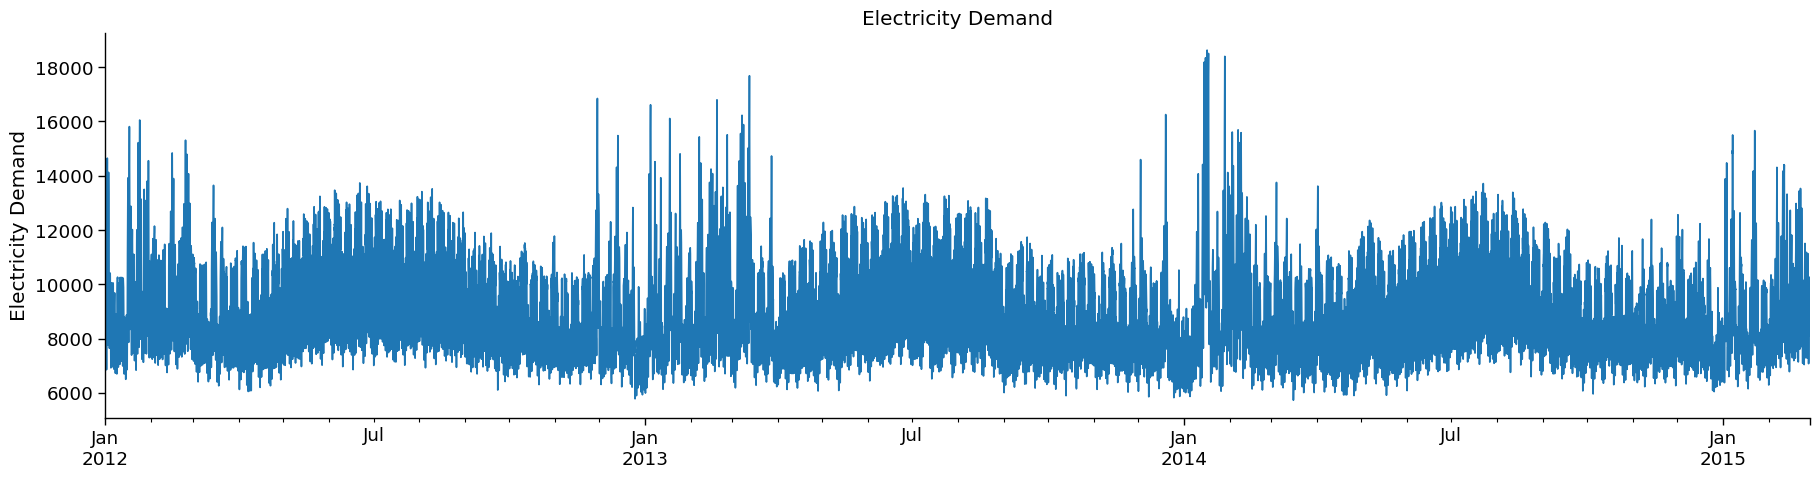

In [27]:
data.loc["2012":].plot(legend=None)

plt.title("Electricity Demand")
plt.xlabel("")
plt.ylabel("Electricity Demand")
plt.show()

In [28]:
df = data.copy()

## 2) Feature engineering

### 2.1) Pandas: seasonal dummies
Seasonal dummies: are specific for linear models, using datetime features and then one-hot encoding.

In [29]:
df["month_of_year"] = df.index.month
df["week_of_year"] = df.index.isocalendar().week

df.head()

,demand,month_of_year,week_of_year
date_time,,,
2002-01-01 00:00:00,"6,919.3661",1,1
2002-01-01 01:00:00,"7,165.9742",1,1
2002-01-01 02:00:00,"6,406.5430",1,1
2002-01-01 03:00:00,"5,815.5378",1,1
2002-01-01 04:00:00,"5,497.7329",1,1


In [30]:
# One-hot transformer
transformer = OneHotEncoder(
    sparse_output=False, # Pandas output
    drop="first", # n-1 one-hot encoding
)

result = transformer.fit_transform(df[["month_of_year", "week_of_year"]])

print(result.shape)
result.head()

(115368, 63)


,month_of_year_2,month_of_year_3,month_of_year_4,month_of_year_5,month_of_year_6,month_of_year_7,month_of_year_8,month_of_year_9,month_of_year_10,month_of_year_11,month_of_year_12,week_of_year_2.0,week_of_year_3.0,week_of_year_4.0,week_of_year_5.0,week_of_year_6.0,week_of_year_7.0,week_of_year_8.0,week_of_year_9.0,week_of_year_10.0,week_of_year_11.0,week_of_year_12.0,week_of_year_13.0,week_of_year_14.0,week_of_year_15.0,week_of_year_16.0,week_of_year_17.0,week_of_year_18.0,week_of_year_19.0,week_of_year_20.0,week_of_year_21.0,week_of_year_22.0,week_of_year_23.0,week_of_year_24.0,week_of_year_25.0,week_of_year_26.0,week_of_year_27.0,week_of_year_28.0,week_of_year_29.0,week_of_year_30.0,week_of_year_31.0,week_of_year_32.0,week_of_year_33.0,week_of_year_34.0,week_of_year_35.0,week_of_year_36.0,week_of_year_37.0,week_of_year_38.0,week_of_year_39.0,week_of_year_40.0,week_of_year_41.0,week_of_year_42.0,week_of_year_43.0,week_of_year_44.0,week_of_year_45.0,week_of_year_46.0,week_of_year_47.0,week_of_year_48.0,week_of_year_49.0,week_of_year_50.0,week_of_year_51.0,week_of_year_52.0,week_of_year_53.0
date_time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2002-01-01 00:00:00,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2002-01-01 01:00:00,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2002-01-01 02:00:00,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2002-01-01 03:00:00,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2002-01-01 04:00:00,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


### 2.2) Forecast Pipeline: sktime

In [31]:
seasonal_dummies = [
    "week_of_year",
    "month_of_year",
]

# Create the DateTimeFeatures transformer
datetime_transformer = DateTimeFeatures(
    manual_selection=seasonal_dummies,
    keep_original_columns=False, # Flag if we want to keep columns in dataframe passed to `transform`.
)

# One hot encoder
one_hot_encoder = OneHotEncoder(
    sparse_output=False, # Required to enable pandas output.
    drop="first", # n-1
)

# Combine the two transformers in a pipeline
seasonal_dummies_feats = make_pipeline(datetime_transformer, one_hot_encoder)
seasonal_dummies_feats

Pipeline(steps=[('datetimefeatures',
                 DateTimeFeatures(manual_selection=['week_of_year', 'month_of_year'])),
                ('onehotencoder',
                 OneHotEncoder(drop='first', sparse_output=False))])

In [32]:
# Fit and transform to create our features
result = seasonal_dummies_feats.fit_transform(data)

print(result.shape)
result.head()

(115368, 63)


,month_of_year_2,month_of_year_3,month_of_year_4,month_of_year_5,month_of_year_6,month_of_year_7,month_of_year_8,month_of_year_9,month_of_year_10,month_of_year_11,month_of_year_12,week_of_year_2,week_of_year_3,week_of_year_4,week_of_year_5,week_of_year_6,week_of_year_7,week_of_year_8,week_of_year_9,week_of_year_10,week_of_year_11,week_of_year_12,week_of_year_13,week_of_year_14,week_of_year_15,week_of_year_16,week_of_year_17,week_of_year_18,week_of_year_19,week_of_year_20,week_of_year_21,week_of_year_22,week_of_year_23,week_of_year_24,week_of_year_25,week_of_year_26,week_of_year_27,week_of_year_28,week_of_year_29,week_of_year_30,week_of_year_31,week_of_year_32,week_of_year_33,week_of_year_34,week_of_year_35,week_of_year_36,week_of_year_37,week_of_year_38,week_of_year_39,week_of_year_40,week_of_year_41,week_of_year_42,week_of_year_43,week_of_year_44,week_of_year_45,week_of_year_46,week_of_year_47,week_of_year_48,week_of_year_49,week_of_year_50,week_of_year_51,week_of_year_52,week_of_year_53
date_time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2002-01-01 00:00:00,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2002-01-01 01:00:00,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2002-01-01 02:00:00,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2002-01-01 03:00:00,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2002-01-01 04:00:00,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


In [33]:
target = ["demand"]

df = data.copy()
df.head()

,demand
date_time,
2002-01-01 00:00:00,"6,919.3661"
2002-01-01 01:00:00,"7,165.9742"
2002-01-01 02:00:00,"6,406.5430"
2002-01-01 03:00:00,"5,815.5378"
2002-01-01 04:00:00,"5,497.7329"


In [34]:
# Polynomial time features for trend
time_feats = make_pipeline(
    TimeSince(), 
    PolynomialFeatures(degree=1, include_bias=False)
)


# Create the seasonal dummies transformer.
datetime_features = [
    "month_of_year",
    "day_of_week",
    "hour_of_day",
]
# Datetime features
datetime_feats = DateTimeFeatures(
    manual_selection=datetime_features, 
    keep_original_columns=False, 
)
# One-hot encoding
one_hot_encoder = OneHotEncoder(
    sparse_output=False, 
    drop="first",
)
seasonal_dummies_feats = make_pipeline(datetime_feats, one_hot_encoder)


# Compute lag & window features.
lag_window_feats = WindowSummarizer(
    lag_feature={
        "lag": [1, 2, 3, 4, 5, 6, 7, 24],  # Lag features.
        "mean": [[1, 24], [1, 24*7]],
    },
    target_cols=target,
    truncate="bfill",  # Backfill missing values from lagging and windowing.
)

# Combine pipelines
pipeline = make_union(
    seasonal_dummies_feats,
    time_feats, 
    lag_window_feats,
)

# Apply min-max scaling to all the features
pipeline = make_pipeline(pipeline, MinMaxScaler())
pipeline

Pipeline(steps=[('featureunion',
                 FeatureUnion(transformer_list=[('pipeline-1',
                                                 Pipeline(steps=[('datetimefeatures',
                                                                  DateTimeFeatures(manual_selection=['month_of_year', 'day_of_week',
                                   'hour_of_day'])),
                                                                 ('onehotencoder',
                                                                  OneHotEncoder(drop='first',
                                                                                sparse_output=False))])),
                                                ('pipeline-2',
                                                 Pipeline(steps=[('timesince',
                                                                  TimeSince()),
                                                                 ('polynomialfeatures',
                                                                  PolynomialFeatures(degree=1,
                                                                                     include_bias=False))])),
                                                ('windowsummarizer',
                                                 WindowSummarizer(lag_feature={'lag': [1, 2, 3, 4, 5, 6, 7, 24],
                              'mean': [[1, 24], [1, 168]]},
                 target_cols=['demand'], truncate='bfill'))])),
                ('minmaxscaler', MinMaxScaler())])

In [35]:
pipeline.fit_transform(df).head()

,month_of_year_2,month_of_year_3,month_of_year_4,month_of_year_5,month_of_year_6,month_of_year_7,month_of_year_8,month_of_year_9,month_of_year_10,month_of_year_11,month_of_year_12,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,hour_of_day_1,hour_of_day_2,hour_of_day_3,hour_of_day_4,hour_of_day_5,hour_of_day_6,hour_of_day_7,hour_of_day_8,hour_of_day_9,hour_of_day_10,hour_of_day_11,hour_of_day_12,hour_of_day_13,hour_of_day_14,hour_of_day_15,hour_of_day_16,hour_of_day_17,hour_of_day_18,hour_of_day_19,hour_of_day_20,hour_of_day_21,hour_of_day_22,hour_of_day_23,time_since_2002-01-01 00:00:00,demand_lag_1,demand_lag_2,demand_lag_3,demand_lag_4,demand_lag_5,demand_lag_6,demand_lag_7,demand_lag_24,demand_mean_1_24,demand_mean_1_168
date_time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2002-01-01 00:00:00,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.1129,0.1129,0.1129,0.1129,0.1129,0.1129,0.1129,0.1129,0.0028,0.0038
2002-01-01 01:00:00,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.1129,0.1129,0.1129,0.1129,0.1129,0.1129,0.1129,0.1129,0.0028,0.0038
2002-01-01 02:00:00,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.1311,0.1129,0.1129,0.1129,0.1129,0.1129,0.1129,0.1129,0.0028,0.0038
2002-01-01 03:00:00,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0752,0.1311,0.1129,0.1129,0.1129,0.1129,0.1129,0.1129,0.0028,0.0038
2002-01-01 04:00:00,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0316,0.0752,0.1311,0.1129,0.1129,0.1129,0.1129,0.1129,0.0028,0.0038


In [36]:
pipeline = clone(pipeline)

## 3) Recursive Forecast

In [37]:
NUM_WEEKS = 2

# --- CONFIG --- #
# Define time of first forecast, this determines our train / test split.                                              
forecast_start_time = df.index.max() - pd.DateOffset(weeks=NUM_WEEKS) # Start two weeks from the end.

# Define number of steps to forecast.
num_of_forecast_steps = 24*7*NUM_WEEKS

# Create a list of periods that we'll forecast over.
forecast_horizon = pd.date_range(
    forecast_start_time, 
    periods=num_of_forecast_steps,
    freq="H"
)

# We need the latest 24*7 time periods in our predict dataframe to build our  window features.
look_back_window_size = pd.DateOffset(weeks=1) 

### 3.1) Train/Test split

In [38]:
df_train = df.loc[df.index < forecast_start_time].copy()
df_test = df.loc[df.index >= forecast_start_time].copy()

# Create X_train and y_train
y_train = df_train[target]
X_train = pipeline.fit_transform(df_train)

In [39]:
# Define the model.
model = LinearRegression()

# Rename column names if is lightGBM
if "lightgbm" in model.__module__:
    X_train = X_train.rename(columns = lambda x:re.sub("[^A-Za-z0-9_]+", "_", x))

# Train one-step ahead forecast model
model.fit(X_train, y_train)

LinearRegression()

In [40]:
# --- CREATE DYNAMIC PREDICTION DATAFRAME  --- #
look_back_start_time = forecast_start_time - look_back_window_size

# Create `df_predict` which has data going as far back as needed to create features which need past values.
df_predict = df_train.loc[look_back_start_time:].copy()

# Extend index into forecast horizon
df_predict = pd.concat([
    df_predict,
    pd.DataFrame(index=forecast_horizon)
])

# --- RECURSIVE FORECASTING LOOP --- #
for forecast_time in tqdm(forecast_horizon):    
    # Compute features during the forecast horizon
    X_test = pipeline.transform(df_predict)
    X_test = X_test.loc[[forecast_time]] 
    # Predict one step ahead. 
    y_pred = model.predict(X_test)
    # Append forecast to the target variable columnn in our dynamic forecast dataframe `df_predict`. 
    df_predict.loc[[forecast_time], target] = y_pred

# --- GET FORECAST AND TEST VALUES --- #    
y_forecast = df_predict.loc[forecast_horizon, target]
y_test = df_test.loc[forecast_start_time:, target]

100%|██████████| 336/336 [01:04<00:00,  5.17it/s]


In [41]:
# --- CREATE IN-SAMPLE PREDICTIONS--- #
y_forecast_train = model.predict(X_train)
y_forecast_train = pd.DataFrame(y_forecast_train, index=X_train.index, columns=target)

### 3.2) Plot results

In [42]:
# Error metrics:
comp_forecast_real = pd.merge(
    left=y_forecast, 
    right=y_test, 
    left_index=True, 
    right_index=True).rename(columns={"demand_x": "forecast", "demand_y": "real"})

mape = c_mape(y=comp_forecast_real["real"], y_hat=comp_forecast_real["forecast"])
mse = mean_squared_error(
    y_true=y_test.loc[y_forecast.index],
    y_pred=y_forecast,
    squared=False
)

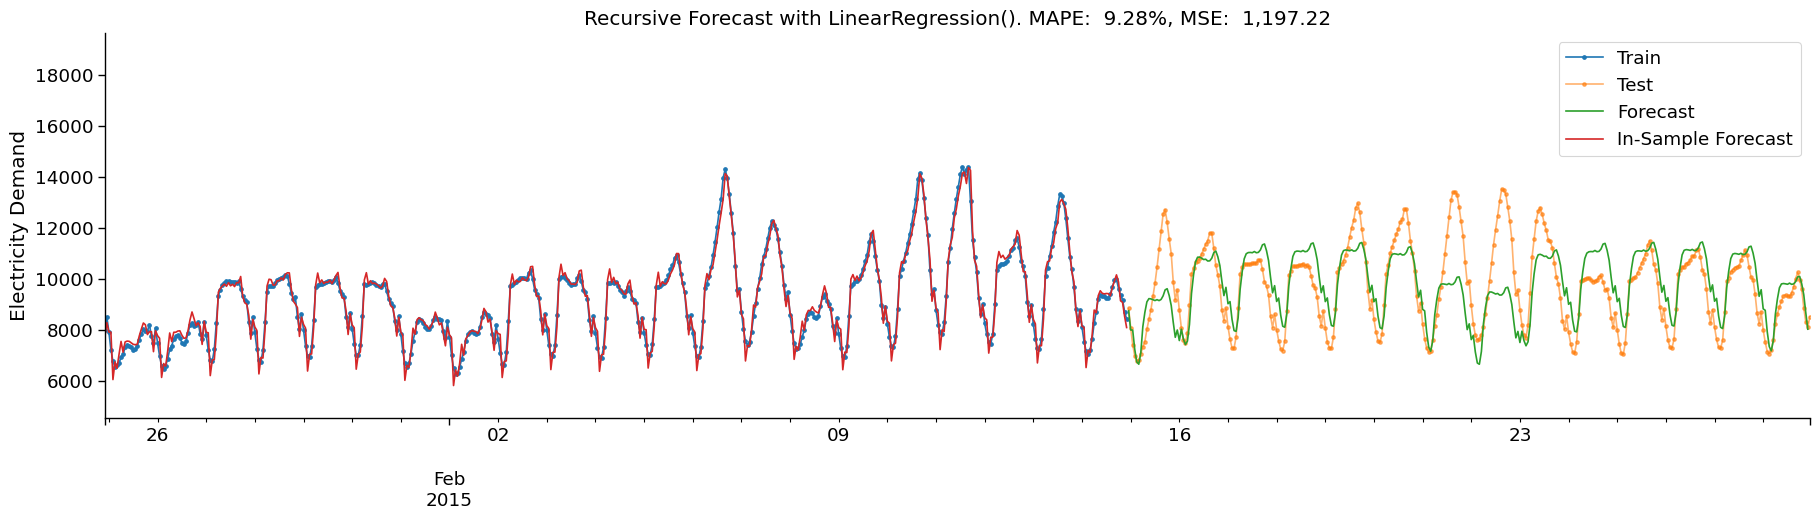

In [43]:
WEEK_PLOT = 3

fig, ax = plt.subplots()

# Plot training set.
y_train.plot(ax=ax, marker='.')
y_test.plot(ax=ax, marker='.', alpha=0.6)

y_forecast.plot(ax=ax)
y_forecast_train.plot(ax=ax)

ax.set_title(f"Recursive Forecast with {model}. MAPE: {mape: .2%}, MSE: {mse: ,.2f}")
ax.legend(["Train", "Test", "Forecast", "In-Sample Forecast"])

ax.set_xlim(xmin=y_train.index.max() - pd.DateOffset(weeks=WEEK_PLOT))
ax.set_xlabel("")
ax.set_ylabel("Electricity Demand")

plt.show()

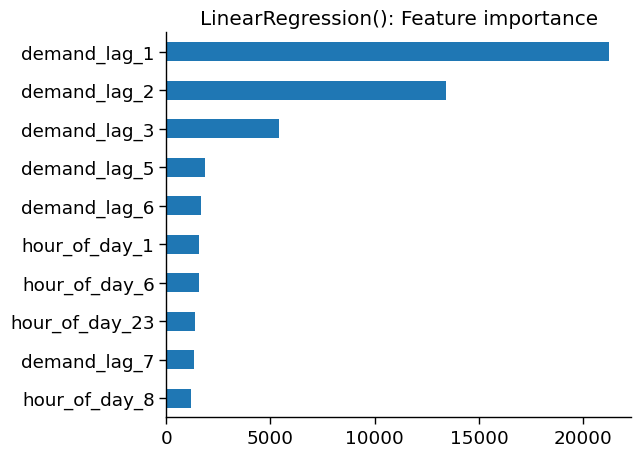

In [44]:
TOP_N = 10

pd.Series(model.coef_[0], index=X_train.columns)\
    .abs()\
    .nlargest(TOP_N)\
    [::-1]\
    .plot(kind="barh", figsize=(6,5)
)

plt.title(f"{model}: Feature importance")
plt.show()